In [9]:
import time
import cv2
import mujoco as mj
import mujoco.viewer
import mujoco.glfw

import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.spatial import ConvexHull
from utility import unit
from controller import Controller

from human import Human
import time
import mujoco

import mujoco.renderer
import mujoco.glfw
import numpy as np
import open3d as o3d
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from sensors import Sensors

In [12]:
def move_simple(name, *, t, func, axis=-1, model):
  model.site(name).pos[axis] = func(t)

In [13]:
# Loading the model and data
m = mj.MjModel.from_xml_path('./mjcf/tec.xml')
d = mj.MjData(m)

# Create a renderer for data collection
r = mujoco.Renderer(m, 480, 640) # RGB = 1080 x 1920  default =  900, 1200   Depth =  640 x 480
ren_orig = mujoco.Renderer(m, 480, 640) # RGB = 1080 x 1920  default =  900, 1200   Depth =  640 x 480
ren_dep = mujoco.Renderer(m, 480, 640) # RGB = 1080 x 1920  default =  900, 1200   Depth =  640 x 480
ren_seg = mujoco.Renderer(m, 480, 640) # RGB = 1080 x 1920  default =  900, 1200   Depth =  640 x 480
opt = mujoco.MjvOption()
opt.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
cam = mujoco.MjvCamera()

sensor = Sensors()
frame = 0

result = {}
poses = []
rotations = []
points = []

point = []
point_cloud = []

t = 0
start_sim = d.time
z_angle = 0
with mujoco.viewer.launch_passive(m, d) as viewer:
    # Close the viewer automatically after 30 wall-seconds.
    with viewer.lock():
    
      viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(d.time % 2)
    # Pick up changes to the physics state, apply perturbations, update options from GUI.
    viewer.sync()
    
    start = time.time()
    while viewer.is_running() and time.time() - start < 2:
      step_start = time.time()
    
      #move_simple('human1', t=t, func=lambda x: (np.sin(x)+1)/2 * 0.2 + 0.05, axis=-1, model=m)
      #move_simple('human2', t=t, func=lambda x: (np.sin(x*2)+1)/2 * 0.2 + 0.05, axis=-1, model=m)
      #move_simple('human3', t=t, func=lambda x: (np.sin(x*3)+1)/2 * 0.2 + 0.05, axis=-1, model=m)
      mujoco.mj_step(m, d)

      t += 0.1

      # Pick up changes to the physics state, apply perturbations, update options from GUI.
      ren_dep.enable_depth_rendering()
      ren_seg.enable_segmentation_rendering()
      # Get RGB, depth, and segmentation images
      readings = sensor.get_rgbd_seg_matrices(m, d, ren_orig, ren_dep, ren_seg)
      print(readings)

      if d.time - start_sim > 0.092:
    
        frame = frame +1
        start_sim = d.time

      # Rudimentary time keeping, will drift relative to wall clock.
      time_until_next_step = m.opt.timestep - (time.time() - step_start)
      if time_until_next_step > 0:
        time.sleep(time_until_next_step)
      time.sleep(0.01)
    ren_dep.disable_depth_rendering()
    ren_seg.disable_segmentation_rendering()
    

{0: array([[[ 1.80000000e+02,  1.80000000e+02,  1.80000000e+02,
                     nan, -1.00000000e+00],
        [ 1.80000000e+02,  1.80000000e+02,  1.80000000e+02,
                     nan, -1.00000000e+00],
        [ 1.80000000e+02,  1.80000000e+02,  1.80000000e+02,
                     nan, -1.00000000e+00],
        ...,
        [ 1.80000000e+02,  1.80000000e+02,  1.80000000e+02,
                     nan, -1.00000000e+00],
        [ 1.80000000e+02,  1.80000000e+02,  1.80000000e+02,
                     nan, -1.00000000e+00],
        [ 1.80000000e+02,  1.80000000e+02,  1.80000000e+02,
                     nan, -1.00000000e+00]],

       [[ 1.80000000e+02,  1.80000000e+02,  1.80000000e+02,
                     nan, -1.00000000e+00],
        [ 1.80000000e+02,  1.80000000e+02,  1.80000000e+02,
                     nan, -1.00000000e+00],
        [ 1.80000000e+02,  1.80000000e+02,  1.80000000e+02,
                     nan, -1.00000000e+00],
        ...,
        [ 1.80000000e+02,  1.800

In [24]:
# Retrieve data from the cameras
frames = [readings[i][:, :, 3] for i in range(len(readings))]
segments = [readings[i][:, :, 4] for i in range(len(readings))]

poses = []
rotations = []
for i in range(m.cam_user.shape[0]):
# Get the position of the camera
  pos = m.cam_pos[i] + m.body(m.cam_bodyid[i]).pos
  poses.append(pos)

  # Get the rotation of the camera
  angle = R.from_quat(m.body(m.cam_bodyid[i]).quat).as_euler('xyz', degrees=True)
  rotations.append(angle[0])


In [25]:
# Generate point cloud from depth image
import point_cloud as pcu


point_cloud = pcu.PointCloud((480, 640), 60, downsample=2)
# Create point cloud based on the data retrieved from the camera
mat = point_cloud.get_map(frames, poses, rotations)

# Creates the feature vectors for each agents in the map
segemented_mat = point_cloud.get_segmented_map(frames, segments, poses, rotations, m)

# Gets the average of the the feature vectors
feature_vectors = point_cloud.get_feature_vectors(segmented_map=segemented_mat)

# Creates a weight average feature vector for each agent in the map
mat_avg = point_cloud.get_segmented_weigavg_map(frames, segments, poses, rotations, m)

In [27]:
feature_vectors

{'human4': array([0.48722902, 0.00099398, 0.11393244, 0.        ]),
 'human3': array([0.27531873, 0.00828405, 0.07112563, 0.        ]),
 'human1': array([ 0.19287552, -0.20846223,  0.06794541,  0.        ]),
 'human2': array([0.191575  , 0.2111104 , 0.07312068, 0.        ]),
 'robot4': array([0.19055383, 0.59772315, 0.10120565, 2.5       ]),
 'robot2': array([-0.02480638,  0.21377598,  0.09677294,  2.3       ]),
 'robot1': array([-0.02322395, -0.02516088,  0.09976565, 20.5       ]),
 'robot3': array([ 0.18944616, -0.59772323,  0.10120564, 38.1       ])}

In [26]:
mat_avg['human4']

array([ 4.88354301e-01, -1.51156938e-03,  1.14027248e-01,  0.00000000e+00,
        7.14120000e+04])

In [19]:
mat_avg

{'human4': array([ 4.88354301e-01, -1.51156938e-03,  1.14027248e-01,  0.00000000e+00,
         7.14120000e+04]),
 'human3': array([2.73511768e-01, 7.02726529e-03, 7.24573634e-02, 0.00000000e+00,
        2.17810000e+04]),
 'human1': array([ 1.95296749e-01, -2.05214582e-01,  7.15308971e-02,  0.00000000e+00,
         6.16500000e+03]),
 'human2': array([1.92570824e-01, 2.04744670e-01, 7.98525943e-02, 0.00000000e+00,
        5.71200000e+03]),
 'robot4': array([1.90553834e-01, 5.97723150e-01, 1.01205648e-01, 0.00000000e+00,
        6.92000000e+02]),
 'robot2': array([-2.41407279e-02,  2.10918682e-01,  9.77709028e-02,  0.00000000e+00,
         7.41000000e+03]),
 'robot1': array([-2.55690135e-02, -2.97942492e-02,  9.86756011e-02,  0.00000000e+00,
         6.16300000e+03]),
 'robot3': array([ 1.89446164e-01, -5.97723230e-01,  1.01205637e-01,  0.00000000e+00,
         3.46000000e+02])}

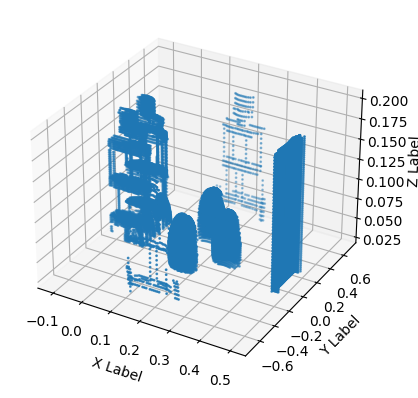

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Define the x, y, z coordinates of the point cloud
x = mat[:, 0]
y = mat[:, 1]
z = mat[:, 2]

# Plot the point cloud data
ax.scatter(x, y, z, s=1)

# Set the axis labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()

(24795, 3)


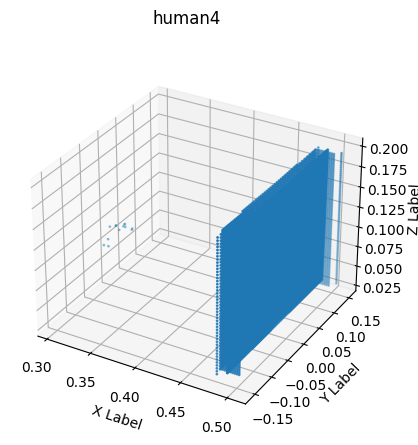

(7112, 3)


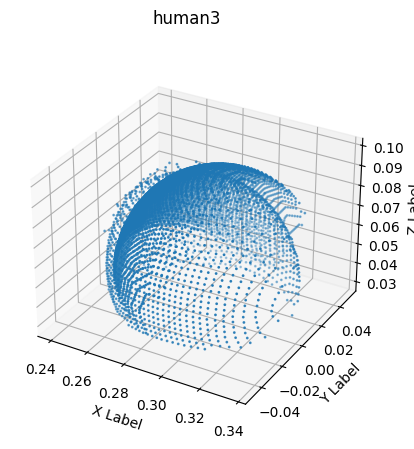

(2814, 3)


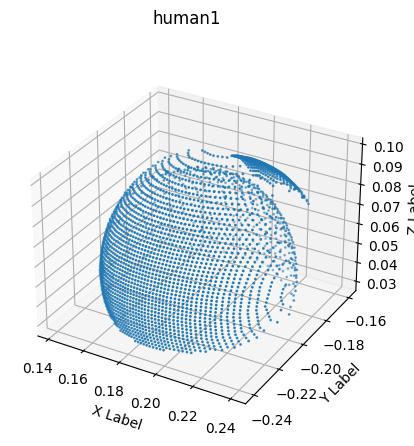

(3327, 3)


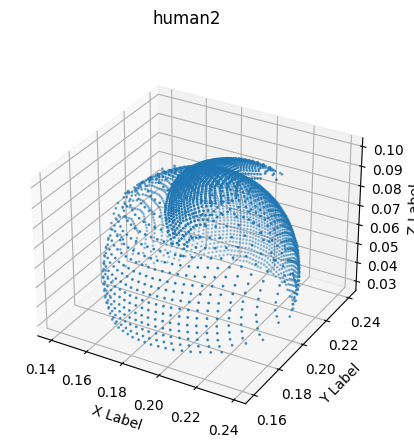

(346, 3)


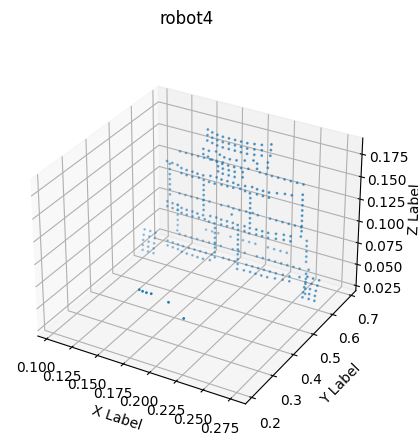

(6710, 3)


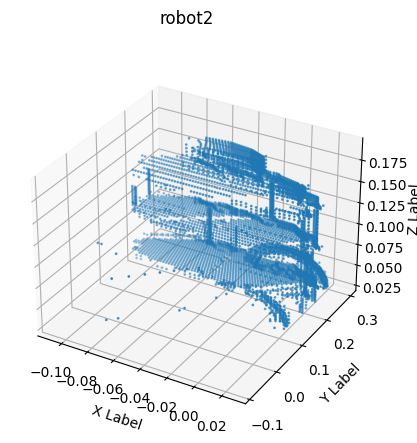

(3797, 3)


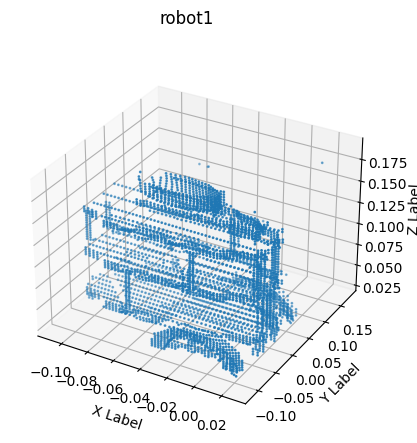

(346, 3)


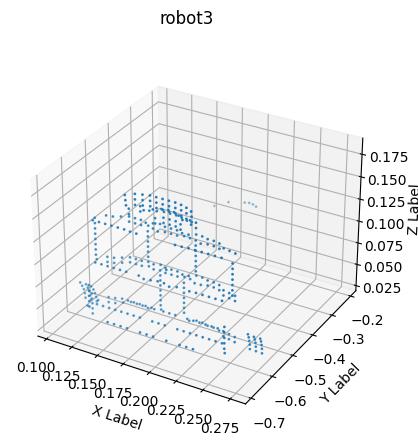

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


for key in segemented_mat.keys():
    mat = np.array(segemented_mat[key])
    print(mat.shape)

    # Create a 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    fig.suptitle(key)

    # Define the x, y, z coordinates of the point cloud
    x = np.append(mat[:, 0], mat_avg[key][0])
    y = np.append(mat[:, 1], mat_avg[key][1])
    z = np.append(mat[:, 2], mat_avg[key][2])

    # Plot the point cloud data
    ax.scatter(x, y, z, s=1)

    # Set the axis labels
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    # Show the plot
    plt.show()